In [4]:
import numpy as np
import json


def world_to_camera(world_point, calib_params):
    """
    Function to transform world coordinates to camera coordinates using homogeneous transformation
    """
    # Extract extrinsics and do some and invert z and y
    translation = np.array(calib_params['extrinsics']['coordinatesOrigin'])
    grid_x = np.array(calib_params['extrinsics']['gridXVec'])
    grid_z = np.array(calib_params['extrinsics']['gridZVec'])
    up_vec = np.array(calib_params['extrinsics']['upVec'])
    grid_y = grid_z
    grid_z = up_vec


    # Create rotation matrix from the camera extrinsics
    R = np.column_stack((grid_x, grid_y, grid_z))

    # Create a 3x4 rotation-translation matrix [R|t]
    Rt = np.column_stack((R, translation))

    Rt_homogeneous = np.vstack([Rt, [0, 0, 0, 1]])


    # Convert world_point to homogeneous coordinates
    world_point_homogeneous = np.append(world_point, 1)  # [X_w, Y_w, Z_w, 1]

    # Apply the homogeneous transformation: P_c = [R|t] * P_w
    camera_point = Rt_homogeneous @ world_point_homogeneous

    # Return the transformed point (camera coordinates)
    return camera_point[:3]


class Vector3D:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, scalar):
        return Vector3D(self.x * scalar, self.y * scalar, self.z * scalar)

    def dot(self, other):
        return self.x * other.x + self.y * other.y + self.z * other.z

    def cross(self, other):
        return Vector3D(
            self.y * other.z - self.z * other.y,
            self.z * other.x - self.x * other.z,
            self.x * other.y - self.y * other.x
        )

    def magnitude(self):
        return np.sqrt(self.x**2 + self.y**2 + self.z**2)

    def normalize(self):
        mag = self.magnitude()
        return Vector3D(self.x / mag, self.y / mag, self.z / mag)

    def to_array(self):
        return np.array([self.x, self.y, self.z])

class Ray:
    def __init__(self, origin, direction):
        self.origin = origin
        self.direction = direction.normalize()

class Box2DIn3D:
    """
    This is just a 2D rectangle in 3D with some helping functions
    """
    def __init__(self, p1, p2, p3, p4):
        self.vertices = [p1, p2, p3, p4]
        self.normal = (p2 - p1).cross(p3 - p1).normalize()

    def intersect(self, ray):
        """
        Check if a ray hit the rectangle
        """
        # Check if ray is parallel to the plane
        denom = ray.direction.dot(self.normal)
        if abs(denom) < 1e-6:
            return False

        # Calculate distance from ray origin to plane
        t = (self.vertices[0] - ray.origin).dot(self.normal) / denom

        # Check if intersection point is behind the ray origin
        if t < 0:
            return False

        # Calculate intersection point
        intersection = ray.origin + ray.direction * t

        # Check if intersection point is inside the quadrilateral
        return self.point_inside_quad(intersection)

    def point_inside_quad(self, point):
        def sign(p1, p2, p3):
            return (p1.x - p3.x) * (p2.y - p3.y) - (p2.x - p3.x) * (p1.y - p3.y)

        d1 = sign(point, self.vertices[0], self.vertices[1])
        d2 = sign(point, self.vertices[1], self.vertices[2])
        d3 = sign(point, self.vertices[2], self.vertices[3])
        d4 = sign(point, self.vertices[3], self.vertices[0])

        has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0) or (d4 < 0)
        has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0) or (d4 > 0)

        return not (has_neg and has_pos)


#Testing that camera origin is near  0,0,0
calib_params = {
    "extrinsics": {
        "coordinatesOrigin": [-265321.4105484304, 23052.4652946497, -73810.18919660046],  # Translation vector
        "gridXVec": [0.8254438775149248, 0.3527933700835317, -0.4406577391788667],
        "gridZVec": [0.5594475450556228, -0.4072366690976891, 0.7219257161740776],
        "upVec": [0.07523861644370015, -0.8424340528298476, -0.533520400011391]
    },
    "intrinsics": {
        "camCenterHeight": 632.1965575634032,
        "camCenterWidth": 1115.0406699188213,
        "fConstantHoriz": 1137.157655643505,
        "fConstantVert": 1117.1416968233184,
        "imageHeight": 1080.0,
        "imageWidth": 1920.0,
        "k1": -0.26315237533704033,
        "k2": 0.05680814827687795
    }
}
"""
with open('cam_1_2_calib.json', 'r') as file:
        calib_params = json.load(file)
"""
realWorldCameraOrigin = (178350.146, 211106.695, 3.35594336)
camera_coords = world_to_camera(realWorldCameraOrigin, calib_params)
print("Camera Coordinates:", camera_coords)
realWolrdCameraOrigin = (178350.146, 211106.695, 3.35594336)
print(world_to_camera(realWolrdCameraOrigin, calib_params))

Camera Coordinates: [ 0.00028025 -0.00010011  0.00019759]
[ 0.00028025 -0.00010011  0.00019759]


In [5]:
# B1 coordinates
b1_top_left = (178331.637, 211114.766, 0.0)  # B1 top left
b1_top_right = (178342.740, 211124.966, 0.0)  # B1 top right
b1_bot_right = (178387.154, 211079.469, 0.0)  # B1 bottom right
b1_bot_left = (178375.960, 211067.734, 0.0)  # B1 bottom left

# B2 coordinates
b2_top_left = (178328.658, 211120.295, 0.0)  # B2 top left
b2_top_right = (178337.708, 211128.645, 0.0)  # B2 top right
b2_bot_right = (178341.702, 211124.605, 0.0)  # B2 bottom right
b2_bot_left = (178332.607, 211115.917, 0.0)  # B2 bottom left

# B3 coordinates
b3_top_left = (178329.064, 211124.086, 0.0)  # B3 top left
b3_top_right = (178333.826, 211128.532, 0.0)  # B3 top right
b3_bot_right = (178335.564, 211127.043, 0.0)  # B3 bottom right
b3_bot_left = (178330.576, 211122.348, 0.0)  # B3 bottom left

# B4 coordinates
b4_top_left = (178297.356, 211119.798, 0.0)  # B4 top left
b4_top_right = (178339.423, 211159.157, 0.0)  # B4 top right
b4_bot_right = (178352.016, 211145.481, 0.0)  # B4 bottom right
b4_bot_left = (178310.671, 211106.077, 0.0)  # B4 bottom left

# B5 coordinates
b5_top_left = (178344.207, 211123.680, 0.0)  # B5 top left
b5_top_right = (178354.995, 211133.836, 0.0)  # B5 top right
b5_bot_right = (178359.463, 211129.322, 0.0)  # B5 bottom right
b5_bot_left = (178348.992, 211118.896, 0.0)  # B5 bottom left

# B6 coordinates
b6_top_left = (178375.847, 211090.234, 0.0)  # B6 top left
b6_top_right = (178384.333, 211098.539, 0.0)  # B6 top right
b6_bot_right = (178387.583, 211095.831, 0.0)  # B6 bottom right
b6_bot_left = (178378.556, 211087.616, 0.0)  # B6 bottom left

# B7 coordinates
b7_top_left = (178376.209, 211068.118, 0.0)  # B7 top left
b7_top_right = (178387.357, 211079.041, 0.0)  # B7 top right
b7_bot_right = (178388.170, 211076.468, 0.0)  # B7 bottom right
b7_bot_left = (178377.382, 211066.809, 0.0)  # B7 bottom left


In [6]:
# W1 coordinates
w1_down_left = (178328.455, 211120.340, 0.0)  # W1 down left
w1_down_right = (178330.486, 211122.145, 0.0)  # W1 down right
w1_up_left = (178328.455, 211120.340, 7.0)  # W1 up left
w1_up_right = (178330.486, 211122.145, 7.0)  # W1 up right

# W2 coordinates
w2_down_right = (178330.350, 211122.416, 0.0)  # W2 down right
w2_down_left = (178328.996, 211123.860, 0.0)  # W2 down left
w2_up_right = (178330.350, 211122.416, 7.0)  # W2 up right
w2_up_left = (178328.996, 211123.860, 7.0)  # W2 up left

# W3 coordinates
w3_down_left = (178297.720, 211119.570, 0.0)  # W3 down left
w3_down_right = (178338.880, 211159.380, 0.0)  # W3 down right
w3_up_left = (178297.720, 211119.570, 7.0)  # W3 up left
w3_up_right = (178338.880, 211159.380, 7.0)  # W3 up right

# W4 coordinates
w4_down_left = (178333.803, 211128.543, 0.0)  # W4 down left
w4_down_right = (178335.327, 211127.223, 0.0)  # W4 down right
w4_up_left = (178333.803, 211128.543, 7.0)  # W4 up left
w4_up_right = (178335.327, 211127.223, 7.0)  # W4 up right

# W5 coordinates
w5_down_left = (178335.394, 211127.189, 0.0)  # W5 down left
w5_down_right = (178337.662, 211128.814, 0.0)  # W5 down right
w5_up_left = (178335.394, 211127.189, 7.0)  # W5 up left
w5_up_right = (178337.662, 211128.814, 7.0)  # W5 up right

# W6 coordinates
w6_down_left = (178338.035,211128.814, 0.0)  # W6 down left
w6_down_right = (178341.725,211124.820, 0.0)  # W6 down right (duplicate)
w6_up_left = (178338.035,211128.814, 7.0)  # W6 up left
w6_up_right = (178341.725,211124.820, 7.0)  # W6 up right

# W7 coordinates
w7_down_left = (178341.826, 211124.718, 0.0)  # W7 down left
w7_down_right = (178342.605, 211125.361, 0.0)  # W7 down right
w7_up_left = (178341.826, 211124.718, 7.0)  # W7 up left
w7_up_right = (178342.605, 211125.361, 7.0)  # W7 up right

# W8 coordinates
w8_down_left = (178342.774, 211125.395, 0.0)  # W8 down left
w8_down_right = (178344.027, 211123.906, 0.0)  # W8 down right
w8_up_left = (178342.774, 211125.395, 7.0)  # W8 up left
w8_up_right = (178344.027, 211123.906, 7.0)  # W8 up right

# W9 coordinates
w9_down_left = (178344.230, 211123.906, 0.0)  # W9 down left
w9_down_right = (178354.825, 211133.960, 0.0)  # W9 down right
w9_up_left = (178344.230, 211123.906, 7.0)  # W9 up left
w9_up_right = (178354.825, 211133.960, 7.0)  # W9 up right

# W10 coordinates
w10_down_left = (178349.104, 211118.929, 0.0)  # W10 down left
w10_down_right = (178359.835, 211129.322, 0.0)  # W10 down right
w10_up_left = (178349.104, 211118.929, 7.0)  # W10 up left
w10_up_right = (178359.835, 211129.322, 7.0)  # W10 up right

# W11 coordinates
w11_down_left = (178348.901, 211118.557, 0.0)  # W11 down left
w11_down_right = (178350.289, 211117.068, 0.0)  # W11 down right
w11_up_left = (178348.901, 211118.557, 7.0)  # W11 up left
w11_up_right = (178350.289, 211117.068, 7.0)  # W11 up right



In [7]:
# W12 coordinates
w12_down_a = (178350.121, 211117.478, 0.0)  # W12 down a
w12_down_b = (178351.110, 211118.279, 0.0)  # W12 down b
w12_up_a = (178350.121, 211117.478, 7.0)    # W12 up a
w12_up_b = (178351.110, 211118.279, 7.0)    # W12 up b

# W13 coordinates
w13_down_a = (178354.750, 211117.253, 0.0)  # W13 down a
w13_down_b = (178352.473, 211115.151, 0.0)  # W13 down b
w13_up_a = (178354.750, 211117.253, 7.0)    # W13 up a
w13_up_b = (178352.473, 211115.151, 7.0)    # W13 up b

# W14 coordinates
w14_down_a = (178352.473, 211115.201, 0.0)  # W14 down a
w14_down_b = (178356.201, 211111.223, 0.0)  # W14 down b
w14_up_a = (178352.473, 211115.201, 7.0)    # W14 up a
w14_up_b = (178356.201, 211111.223, 7.0)    # W14 up b

# W15 coordinates
w15_down_a = (178356.327, 211111.323, 0.0)  # W15 down a
w15_down_b = (178357.778, 211112.649, 0.0)  # W15 down b
w15_up_a = (178356.327, 211111.323, 7.0)    # W15 up a
w15_up_b = (178357.778, 211112.649, 7.0)    # W15 up b

# W16 coordinates
w16_down_a = (178359.379, 211111.723, 0.0)  # W16 down a
w16_down_b = (178357.603, 211109.872, 0.0)  # W16 down b
w16_up_a = (178359.379, 211111.723, 7.0)    # W16 up a
w16_up_b = (178357.603, 211109.872, 7.0)    # W16 up b

# W17 coordinates
w17_down_a = (178357.603, 211109.847, 0.0)  # W17 down a
w17_down_b = (178359.304, 211110.347, 0.0)  # W17 down b
w17_up_a = (178357.603, 211109.847, 7.0)    # W17 up a
w17_up_b = (178359.304, 211110.347, 7.0)    # W17 up b

# W18 coordinates
w18_down_a = (178365.159, 211101.990, 0.0)  # W18 down a
w18_down_b = (178366.160, 211100.739, 0.0)  # W18 down b
w18_up_a = (178365.159, 211101.990, 7.0)    # W18 up a
w18_up_b = (178366.160, 211100.739, 7.0)    # W18 up b

# W19 coordinates
w19_down_a = (178366.160, 211100.789, 0.0)  # W19 down a
w19_down_b = (178369.688, 211105.468, 0.0)  # W19 down b
w19_up_a = (178366.160, 211100.789, 7.0)    # W19 up a
w19_up_b = (178369.688, 211105.468, 7.0)    # W19 up b

# W20 coordinates
w20_down_a = (178375.643, 211090.931, 0.0)  # W20 down a
w20_down_b = (178385.451, 211100.764, 0.0)  # W20 down b
w20_up_a = (178375.643, 211090.931, 7.0)    # W20 up a
w20_up_b = (178385.451, 211100.764, 7.0)    # W20 up b

# W21 coordinates
w21_down_a = (178389.754, 211096.736, 0.0)  # W21 down a
w21_down_b = (178386.051, 211093.358, 0.0)  # W21 down b
w21_up_a = (178389.754, 211096.736, 7.0)    # W21 up a
w21_up_b = (178386.051, 211093.358, 7.0)    # W21 up b

# W22 coordinates
w22_down_a = (178385.951, 211093.433, 0.0)  # W22 down a
w22_down_b = (178384.600, 211093.733, 0.0)  # W22 down b
w22_up_a = (178385.951, 211093.433, 7.0)    # W22 up a
w22_up_b = (178384.600, 211093.733, 7.0)    # W22 up b

# W23 coordinates
w23_down_a = (178384.625, 211093.708, 0.0)  # W23 down a
w23_down_b = (178382.148, 211091.532, 0.0)  # W23 down b
w23_up_a = (178384.625, 211093.708, 7.0)    # W23 up a
w23_up_b = (178382.148, 211091.532, 7.0)    # W23 up b

# W30 coordinates
w30_down_a = (178388.303, 211076.694, 0.0)  # W30 down a
w30_down_b = (178389.154, 211075.693, 0.0)  # W30 down b
w30_up_a = (178388.303, 211076.694, 7.0)    # W30 up a
w30_up_b = (178389.154, 211075.693, 7.0)    # W30 up b

# W31 coordinates
w31_down_a = (178387.202, 211076.019, 0.0)  # W31 down a
w31_down_b = (178386.902, 211075.393, 0.0)  # W31 down b
w31_up_a = (178387.202, 211076.019, 7.0)    # W31 up a
w31_up_b = (178386.902, 211075.393, 7.0)    # W31 up b

# W32 coordinates
w32_down_a = (178386.877, 211075.218, 0.0)  # W32 down a
w32_down_b = (178387.653, 211073.592, 0.0)  # W32 down b
w32_up_a = (178386.877, 211075.218, 7.0)    # W32 up a
w32_up_b = (178387.653, 211073.592, 7.0)    # W32 up b

# W33 coordinates
w33_down_a = (178384.900, 211073.291, 0.0)  # W33 down a
w33_down_b = (178384.600, 211072.941, 0.0)  # W33 down b
w33_up_a = (178384.900, 211073.291, 7.0)    # W33 up a
w33_up_b = (178384.600, 211072.941, 7.0)    # W33 up b

# W34 coordinates
w34_down_a = (178381.397, 211070.564, 0.0)  # W34 down a
w34_down_b = (178381.122, 211070.164, 0.0)  # W34 down b
w34_up_a = (178381.397, 211070.564, 7.0)    # W34 up a
w34_up_b = (178381.122, 211070.164, 7.0)    # W34 up b

# W35 coordinates
w35_down_a = (178380.997, 211067.036, 0.0)  # W35 down a
w35_down_b = (178378.920, 211068.137, 0.0)  # W35 down b
w35_up_a = (178380.997, 211067.036, 7.0)    # W35 up a
w35_up_b = (178378.920, 211068.137, 7.0)    # W35 up b

# W37 coordinates
w37_down_a = (178378.895, 211068.287, 0.0)  # W36 down a
w37_down_b = (178377.694, 211066.986, 0.0)  # W36 down b
w37_up_a = (178378.895, 211068.287, 7.0)    # W36 up a
w37_up_b = (178377.694, 211066.986, 7.0)    # W36 up b

# W38 coordinates
w38_down_a = (178377.469, 211066.861, 0.0)  # W37 down a
w38_down_b = (178375.968, 211067.687, 0.0)  # W37 down b
w38_up_a = (178377.469, 211066.861, 7.0)    # W37 up a
w38_up_b = (178375.968, 211067.687, 7.0)    # W37 up b

# W40 coordinates
w40_down_a = (178367.836, 211076.644, 0.0)  # W40 down a
w40_down_b = (178367.136, 211077.345, 0.0)  # W40 down b
w40_up_a = (178367.836, 211076.644, 7.0)    # W40 up a
w40_up_b = (178367.136, 211077.345, 7.0)    # W40 up b

# W50 coordinates
w50_down_a = (178332.532, 211115.852, 0.0)  # W50 down a
w50_down_b = (178331.756, 211115.201, 0.0)  # W50 down b
w50_up_a = (178332.532, 211115.852, 7.0)    # W50 up a
w50_up_b = (178331.756, 211115.201, 7.0)    # W50 up b

# W51 coordinates
w51_down_a = (178334.308, 211112.099, 0.0)  # W51 down a
w51_down_b = (178335.534, 211110.873, 0.0)  # W51 down b
w51_up_a = (178334.308, 211112.099, 7.0)    # W51 up a
w51_up_b = (178335.534, 211110.873, 7.0)    # W51 up b

# W52 coordinates
w52_down_a = (178337.336, 211109.021, 0.0)  # W52 down a
w52_down_b = (178337.886, 211108.521, 0.0)  # W52 down b
w52_up_a = (178337.336, 211109.021, 7.0)    # W52 up a
w52_up_b = (178337.886, 211108.521, 7.0)    # W52 up b

# W53 coordinates
w53_down_a = (178344.392, 211101.115, 0.0)  # W53 down a
w53_down_b = (178344.842, 211100.714, 0.0)  # W53 down b
w53_up_a = (178344.392, 211101.115, 7.0)    # W53 up a
w53_up_b = (178344.842, 211100.714, 7.0)    # W53 up b

# W54 coordinates
w54_down_a = (178356.702, 211088.104, 0.0)  # W54 down a
w54_down_b = (178357.302, 211087.553, 0.0)  # W54 down b
w54_up_a = (178356.702, 211088.104, 7.0)    # W54 up a
w54_up_b = (178357.302, 211087.553, 7.0)    # W54 up b

# W55 coordinates
w55_down_a = (178367.361, 211077.044, 0.0)  # W55 down a
w55_down_b = (178367.711, 211076.344, 0.0)  # W55 down b
w55_up_a = (178367.361, 211077.044, 7.0)    # W55 up a
w55_up_b = (178367.711, 211076.344, 7.0)    # W55 up b



In [8]:
from typing import List, Tuple

In [9]:
def create_box2din3d(points: List[Tuple[float, float, float]], calib_params) -> Box2DIn3D:
    camera_points = [Vector3D(*world_to_camera(np.array(point), calib_params)) for point in points]
    return Box2DIn3D(camera_points[0], camera_points[1], camera_points[2], camera_points[3])

# Create Box2DIn3D objects
b1_box = create_box2din3d([b1_top_left, b1_top_right, b1_bot_right, b1_bot_left], calib_params)
b2_box = create_box2din3d([b2_top_left, b2_top_right, b2_bot_right, b2_bot_left], calib_params)
b3_box = create_box2din3d([b3_top_left, b3_top_right, b3_bot_right, b3_bot_left], calib_params)
b4_box = create_box2din3d([b4_top_left, b4_top_right, b4_bot_right, b4_bot_left], calib_params)
b5_box = create_box2din3d([b5_top_left, b5_top_right, b5_bot_right, b5_bot_left], calib_params)
b6_box = create_box2din3d([b6_top_left, b6_top_right, b6_bot_right, b6_bot_left], calib_params)
b7_box = create_box2din3d([b7_top_left, b7_top_right, b7_bot_right, b7_bot_left], calib_params)

w1_box = create_box2din3d([w1_down_left, w1_down_right, w1_up_right, w1_up_left], calib_params)
w2_box = create_box2din3d([w2_down_left, w2_down_right, w2_up_right, w2_up_left], calib_params)
w3_box = create_box2din3d([w3_down_left, w3_down_right, w3_up_right, w3_up_left], calib_params)
w4_box = create_box2din3d([w4_down_left, w4_down_right, w4_up_right, w4_up_left], calib_params)
w5_box = create_box2din3d([w5_down_left, w5_down_right, w5_up_right, w5_up_left], calib_params)
w6_box = create_box2din3d([w6_down_left, w6_down_right, w6_up_right, w6_up_left], calib_params)
w7_box = create_box2din3d([w7_down_left, w7_down_right, w7_up_right, w7_up_left], calib_params)
w8_box = create_box2din3d([w8_down_left, w8_down_right, w8_up_right, w8_up_left], calib_params)
w9_box = create_box2din3d([w9_down_left, w9_down_right, w9_up_right, w9_up_left], calib_params)
w10_box = create_box2din3d([w10_down_left, w10_down_right, w10_up_right, w10_up_left], calib_params)
w11_box = create_box2din3d([w11_down_left, w11_down_right, w11_up_right, w11_up_left], calib_params)

w12_box = create_box2din3d([w12_down_a, w12_down_b, w12_up_b, w12_up_a], calib_params)
w13_box = create_box2din3d([w13_down_a, w13_down_b, w13_up_b, w13_up_a], calib_params)
w14_box = create_box2din3d([w14_down_a, w14_down_b, w14_up_b, w14_up_a], calib_params)
w15_box = create_box2din3d([w15_down_a, w15_down_b, w15_up_b, w15_up_a], calib_params)
w16_box = create_box2din3d([w16_down_a, w16_down_b, w16_up_b, w16_up_a], calib_params)
w17_box = create_box2din3d([w17_down_a, w17_down_b, w17_up_b, w17_up_a], calib_params)
w18_box = create_box2din3d([w18_down_a, w18_down_b, w18_up_b, w18_up_a], calib_params)
w19_box = create_box2din3d([w19_down_a, w19_down_b, w19_up_b, w19_up_a], calib_params)
w20_box = create_box2din3d([w20_down_a, w20_down_b, w20_up_b, w20_up_a], calib_params)
w21_box = create_box2din3d([w21_down_a, w21_down_b, w21_up_b, w21_up_a], calib_params)
w22_box = create_box2din3d([w22_down_a, w22_down_b, w22_up_b, w22_up_a], calib_params)
w23_box = create_box2din3d([w23_down_a, w23_down_b, w23_up_b, w23_up_a], calib_params)

w30_box = create_box2din3d([w30_down_a, w30_down_b, w30_up_b, w30_up_a], calib_params)
w31_box = create_box2din3d([w31_down_a, w31_down_b, w31_up_b, w31_up_a], calib_params)
w32_box = create_box2din3d([w32_down_a, w32_down_b, w32_up_b, w32_up_a], calib_params)
w33_box = create_box2din3d([w33_down_a, w33_down_b, w33_up_b, w33_up_a], calib_params)
w34_box = create_box2din3d([w34_down_a, w34_down_b, w34_up_b, w34_up_a], calib_params)
w35_box = create_box2din3d([w35_down_a, w35_down_b, w35_up_b, w35_up_a], calib_params)
w37_box = create_box2din3d([w37_down_a, w37_down_b, w37_up_b, w37_up_a], calib_params)
w38_box = create_box2din3d([w38_down_a, w38_down_b, w38_up_b, w38_up_a], calib_params)
w40_box = create_box2din3d([w40_down_a, w40_down_b, w40_up_b, w40_up_a], calib_params)
w50_box = create_box2din3d([w50_down_a, w50_down_b, w50_up_b, w50_up_a], calib_params)
w51_box = create_box2din3d([w51_down_a, w51_down_b, w51_up_b, w51_up_a], calib_params)
w52_box = create_box2din3d([w52_down_a, w52_down_b, w52_up_b, w52_up_a], calib_params)
w53_box = create_box2din3d([w53_down_a, w53_down_b, w53_up_b, w53_up_a], calib_params)
w54_box = create_box2din3d([w54_down_a, w54_down_b, w54_up_b, w54_up_a], calib_params)
w55_box = create_box2din3d([w55_down_a, w55_down_b, w55_up_b, w55_up_a], calib_params)



image_width1920
image_height1080
JSON read success.
Read success.


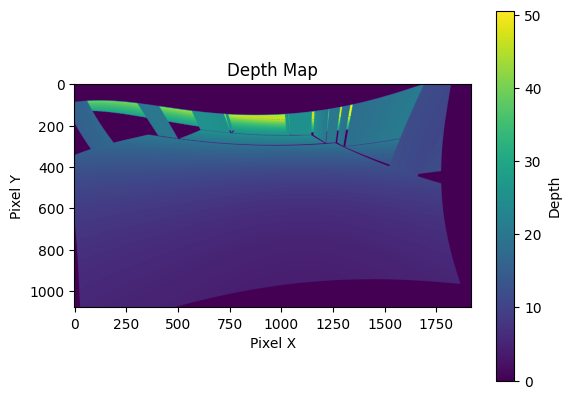

np shape :(1080, 1920)
cam_1_1_calib Depth map generated and saved as 'cam_1_1_calib_depth_map.npy', 'cam_1_1_calib_depth_map.png', and 'cam_1_1_calib_depth_map_plot.png'
image_width1920
image_height1080
JSON read success.
Read success.


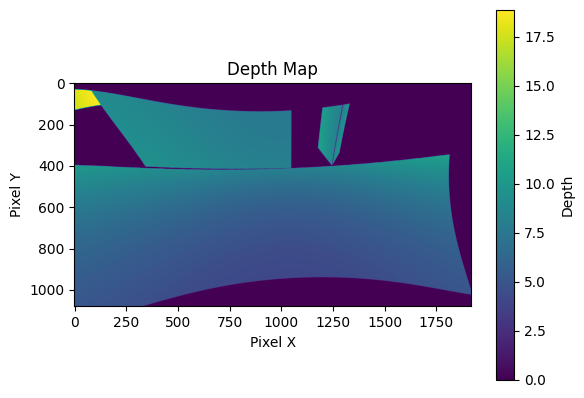

np shape :(1080, 1920)
cam_1_2_calib Depth map generated and saved as 'cam_1_2_calib_depth_map.npy', 'cam_1_2_calib_depth_map.png', and 'cam_1_2_calib_depth_map_plot.png'
image_width1920
image_height1080
JSON read success.
Read success.


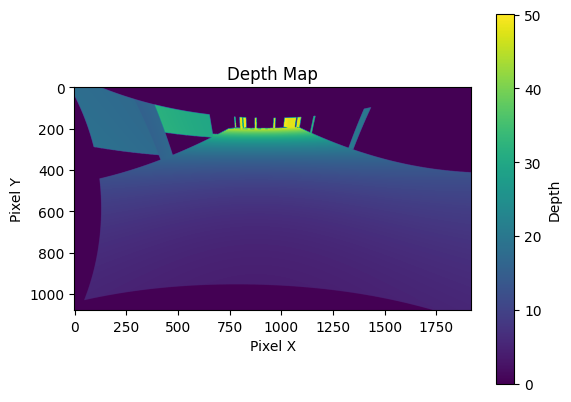

np shape :(1080, 1920)
cam_1_3_calib Depth map generated and saved as 'cam_1_3_calib_depth_map.npy', 'cam_1_3_calib_depth_map.png', and 'cam_1_3_calib_depth_map_plot.png'
image_width1920
image_height1080
JSON read success.
Read success.


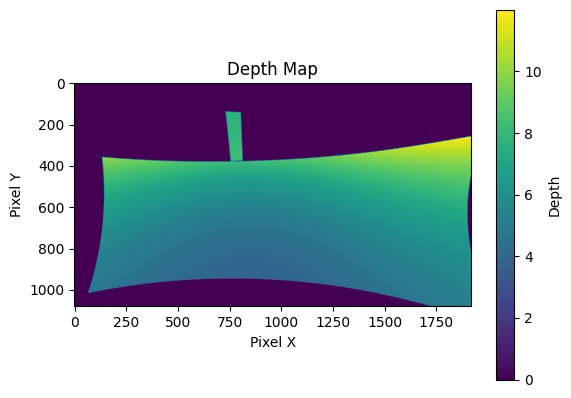

np shape :(1080, 1920)
cam_1_4_calib Depth map generated and saved as 'cam_1_4_calib_depth_map.npy', 'cam_1_4_calib_depth_map.png', and 'cam_1_4_calib_depth_map_plot.png'
image_width1920
image_height1080
JSON read success.
Read success.


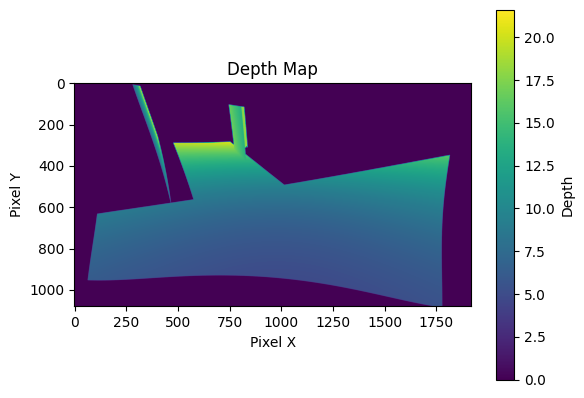

np shape :(1080, 1920)
cam_2_1_calib Depth map generated and saved as 'cam_2_1_calib_depth_map.npy', 'cam_2_1_calib_depth_map.png', and 'cam_2_1_calib_depth_map_plot.png'
image_width1920
image_height1080
JSON read success.
Read success.


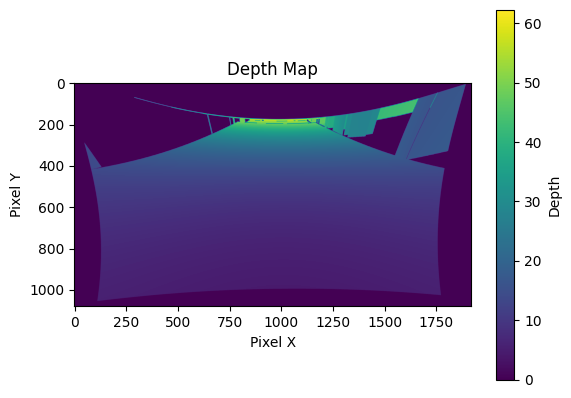

np shape :(1080, 1920)
cam_2_2_calib Depth map generated and saved as 'cam_2_2_calib_depth_map.npy', 'cam_2_2_calib_depth_map.png', and 'cam_2_2_calib_depth_map_plot.png'
image_width1920
image_height1080
JSON read success.
Read success.


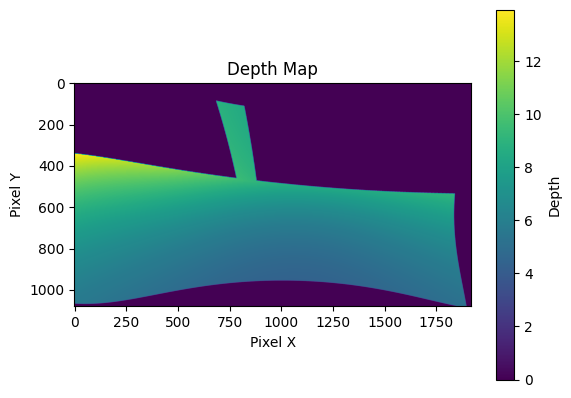

np shape :(1080, 1920)
cam_2_3_calib Depth map generated and saved as 'cam_2_3_calib_depth_map.npy', 'cam_2_3_calib_depth_map.png', and 'cam_2_3_calib_depth_map_plot.png'
image_width1920
image_height1080
JSON read success.
Read success.


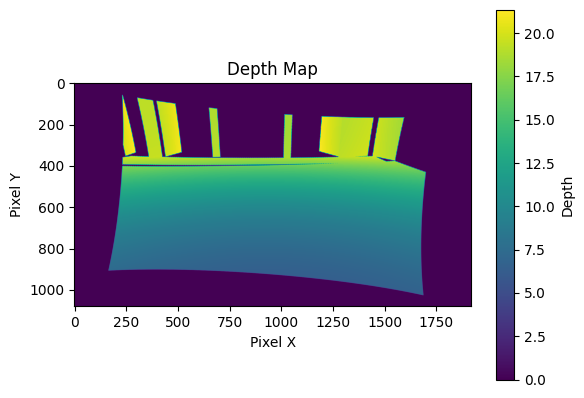

np shape :(1080, 1920)
cam_2_4_calib Depth map generated and saved as 'cam_2_4_calib_depth_map.npy', 'cam_2_4_calib_depth_map.png', and 'cam_2_4_calib_depth_map_plot.png'


In [ ]:
import numpy as np
from typing import List, Tuple
import cv2
from camera_params import CameraParams


def pixel_to_ray(px: float, py: float, calib_params: dict,  camera_params ) -> Ray:
    f_x = calib_params['intrinsics']['fConstantHoriz']
    f_y = calib_params['intrinsics']['fConstantVert']
    c_x = calib_params['intrinsics']['camCenterWidth']
    c_y = calib_params['intrinsics']['camCenterHeight']
    k1 = calib_params['intrinsics']['k1']
    k2 = calib_params['intrinsics']['k2']

    camera_matrix2, distCoeffs,Rmat, newCameraMatrix, size = camera_params.getParams()

    camera_matrix = np.array([[f_x, 0, c_x],
                              [0, f_y, c_y],
                              [0, 0, 1]], dtype=np.float64)





    pixel = np.array([[px, py]], dtype=np.float64)
    dist_coeffs = np.array([k1, k2, 0, 0, 0], dtype=np.float64)

    undistorted_point = cv2.undistortPoints(pixel, camera_matrix, None)

    x, y = undistorted_point[0][0]
    direction = np.array([x, y, 1.0])
    direction /= np.linalg.norm(direction)

    origin = Vector3D(0, 0, 0)

    return Ray(origin, Vector3D(direction[0],direction[1],direction[2]))

def create_undistortion_map(image_width: int, image_height: int, camera_params: CameraParams) -> np.ndarray:
    map1, map2 = camera_params.getMaps()

    y, x = np.indices((image_height, image_width))
    pixel_coords = np.dstack((x, y)).astype(np.float32)

    undistorted_coords = cv2.remap(pixel_coords, map1, map2, cv2.INTER_LINEAR)

    return undistorted_coords

def find_nearest_intersection(ray: Ray, boxes: List[Box2DIn3D]) -> float:
    nearest_distance = float('inf')
    for box in boxes:
        if box.intersect(ray):
            t = (box.vertices[0] - ray.origin).dot(box.normal) / ray.direction.dot(box.normal)
            if 0 < t < nearest_distance:
                nearest_distance = t

    return nearest_distance if nearest_distance != float('inf') else 0.0

def generate_depth_map(image_width: int, image_height: int, calib_params: dict, boxes: List[Box2DIn3D], camera_params) -> np.ndarray:
    depth_map = np.zeros((image_height, image_width), dtype=float)

    for py in range(image_height):
        for px in range(image_width):
            ray = pixel_to_ray(px, py, calib_params, camera_params)
            depth = find_nearest_intersection(ray, boxes)
            depth_map[py, px] = depth

    map1, map2 = camera_params.getMaps()
    undistorted_depth_map = cv2.remap(depth_map, map1, map2, cv2.INTER_LINEAR)

    return undistorted_depth_map

    map1, map2 = camera_params.getMaps()
    return depth_map

name =  'cam_1_1_calib'

import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def transform_string(input_string):
    parts = input_string.split('_')
    if len(parts) != 4 or parts[0] != 'cam':
        raise ValueError("Invalid input string format")


    num1 = int(parts[1])
    num2 = int(parts[2])

    output_string = f"undistort_params_cam_{num1}_{num2}.xml"

    return output_string

def createTheDepthMap(name):
    with open(name + '.json', 'r') as file:
        calib_params = json.load(file)


    b1_box = create_box2din3d([b1_top_left, b1_top_right, b1_bot_right, b1_bot_left], calib_params)
    b2_box = create_box2din3d([b2_top_left, b2_top_right, b2_bot_right, b2_bot_left], calib_params)
    b3_box = create_box2din3d([b3_top_left, b3_top_right, b3_bot_right, b3_bot_left], calib_params)
    b4_box = create_box2din3d([b4_top_left, b4_top_right, b4_bot_right, b4_bot_left], calib_params)
    b5_box = create_box2din3d([b5_top_left, b5_top_right, b5_bot_right, b5_bot_left], calib_params)
    b6_box = create_box2din3d([b6_top_left, b6_top_right, b6_bot_right, b6_bot_left], calib_params)
    b7_box = create_box2din3d([b7_top_left, b7_top_right, b7_bot_right, b7_bot_left], calib_params)

    w1_box = create_box2din3d([w1_down_left, w1_down_right, w1_up_right, w1_up_left], calib_params)
    w2_box = create_box2din3d([w2_down_left, w2_down_right, w2_up_right, w2_up_left], calib_params)
    w3_box = create_box2din3d([w3_down_left, w3_down_right, w3_up_right, w3_up_left], calib_params)
    w4_box = create_box2din3d([w4_down_left, w4_down_right, w4_up_right, w4_up_left], calib_params)
    w5_box = create_box2din3d([w5_down_left, w5_down_right, w5_up_right, w5_up_left], calib_params)
    w6_box = create_box2din3d([w6_down_left, w6_down_right, w6_up_right, w6_up_left], calib_params)
    w7_box = create_box2din3d([w7_down_left, w7_down_right, w7_up_right, w7_up_left], calib_params)
    w8_box = create_box2din3d([w8_down_left, w8_down_right, w8_up_right, w8_up_left], calib_params)
    w9_box = create_box2din3d([w9_down_left, w9_down_right, w9_up_right, w9_up_left], calib_params)
    w10_box = create_box2din3d([w10_down_left, w10_down_right, w10_up_right, w10_up_left], calib_params)
    w11_box = create_box2din3d([w11_down_left, w11_down_right, w11_up_right, w11_up_left], calib_params)

    w12_box = create_box2din3d([w12_down_a, w12_down_b, w12_up_b, w12_up_a], calib_params)
    w13_box = create_box2din3d([w13_down_a, w13_down_b, w13_up_b, w13_up_a], calib_params)
    w14_box = create_box2din3d([w14_down_a, w14_down_b, w14_up_b, w14_up_a], calib_params)
    w15_box = create_box2din3d([w15_down_a, w15_down_b, w15_up_b, w15_up_a], calib_params)
    w16_box = create_box2din3d([w16_down_a, w16_down_b, w16_up_b, w16_up_a], calib_params)
    w17_box = create_box2din3d([w17_down_a, w17_down_b, w17_up_b, w17_up_a], calib_params)
    w18_box = create_box2din3d([w18_down_a, w18_down_b, w18_up_b, w18_up_a], calib_params)
    w19_box = create_box2din3d([w19_down_a, w19_down_b, w19_up_b, w19_up_a], calib_params)
    w20_box = create_box2din3d([w20_down_a, w20_down_b, w20_up_b, w20_up_a], calib_params)
    w21_box = create_box2din3d([w21_down_a, w21_down_b, w21_up_b, w21_up_a], calib_params)
    w22_box = create_box2din3d([w22_down_a, w22_down_b, w22_up_b, w22_up_a], calib_params)
    w23_box = create_box2din3d([w23_down_a, w23_down_b, w23_up_b, w23_up_a], calib_params)


    w30_box = create_box2din3d([w30_down_a, w30_down_b, w30_up_b, w30_up_a], calib_params)
    w31_box = create_box2din3d([w31_down_a, w31_down_b, w31_up_b, w31_up_a], calib_params)
    w32_box = create_box2din3d([w32_down_a, w32_down_b, w32_up_b, w32_up_a], calib_params)
    w33_box = create_box2din3d([w33_down_a, w33_down_b, w33_up_b, w33_up_a], calib_params)
    w34_box = create_box2din3d([w34_down_a, w34_down_b, w34_up_b, w34_up_a], calib_params)
    w35_box = create_box2din3d([w35_down_a, w35_down_b, w35_up_b, w35_up_a], calib_params)
    w37_box = create_box2din3d([w37_down_a, w37_down_b, w37_up_b, w37_up_a], calib_params)
    w38_box = create_box2din3d([w38_down_a, w38_down_b, w38_up_b, w38_up_a], calib_params)
    w40_box = create_box2din3d([w40_down_a, w40_down_b, w40_up_b, w40_up_a], calib_params)
    w50_box = create_box2din3d([w50_down_a, w50_down_b, w50_up_b, w50_up_a], calib_params)
    w51_box = create_box2din3d([w51_down_a, w51_down_b, w51_up_b, w51_up_a], calib_params)
    w52_box = create_box2din3d([w52_down_a, w52_down_b, w52_up_b, w52_up_a], calib_params)
    w53_box = create_box2din3d([w53_down_a, w53_down_b, w53_up_b, w53_up_a], calib_params)
    w54_box = create_box2din3d([w54_down_a, w54_down_b, w54_up_b, w54_up_a], calib_params)
    w55_box = create_box2din3d([w55_down_a, w55_down_b, w55_up_b, w55_up_a], calib_params)
    all_boxes = [b1_box, b2_box, b3_box, b4_box, b5_box, b6_box, b7_box,
              w1_box, w2_box, w3_box, w4_box, w5_box, w6_box, w7_box,
              w8_box, w9_box, w10_box, w11_box,
              w12_box, w13_box, w14_box, w15_box, w16_box, w17_box, w18_box, w19_box,
              w20_box, w21_box, w22_box, w23_box,
              w30_box, w31_box, w32_box, w33_box, w34_box, w35_box, w37_box, w38_box,
              w40_box, w50_box, w51_box, w52_box, w53_box, w54_box, w55_box]


    image_width = int(calib_params['intrinsics']['imageWidth'])
    print(  "image_width" + str(image_width))
    image_height = int(calib_params['intrinsics']['imageHeight'])
    print(  "image_height" + str(image_height))

    camera_params = CameraParams()
    camera_params_json_file = name + '.json'
    camera_params_xml_file = transform_string(name)
    camera_params.read_from_json(camera_params_json_file)
    camera_params.read_from_xml(camera_params_xml_file)


    depth_map = generate_depth_map(image_width, image_height, calib_params, all_boxes,camera_params)

    # Visualize the depth map
    plt.figure()
    plt.imshow(depth_map, cmap='viridis')
    plt.colorbar(label='Depth')
    plt.title('Depth Map')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.show()

    # Save the depth map as a numpy array
    np.save(name + '_depth_map20.npy', depth_map)

    # Save the depth map as a PNG image
    depth_map_normalized = (depth_map - np.min(depth_map)) / (np.max(depth_map) - np.min(depth_map))
    depth_map_img = (depth_map_normalized * 255).astype(np.uint8)
    Image.fromarray(depth_map_img).save(name + '_depth_map20.png')

    print(f"{name} Depth map generated and saved as '{name}_depth_map.npy', '{name}_depth_map.png', and '{name}_depth_map_plot.png'")

for i in range(1, 3):
    for j in range(1, 5):
        createTheDepthMap(f'cam_{i}_{j}_calib')